# <font color=green>Przemek Wołczacki, czerwiec 2021<br>Projekt ze Sztucznej inteligencji: Grupowanie i klasyfikacja danych</font>
## Podstawowe dane dotyczące komputera, na którym wykonano zadania:
Laptop ASUS TUF GAMING A15,<br><br>
__GPU:__ NVIDIA GeForce RTX 2060,<br>
__CPU:__ AMD Ryzen z serii 4000,<br>
__RAM:__ 16 GB DDR4,<br> 
__DYSK:__ SSD 512 GB, <br>
__System:__ Windows 10, 64-bit.<br>

Projekt wykonany w _Python Notebook Jupyter_.


In [1]:
import numpy as np 
import pandas as pd 
import xgboost as xgb
import seaborn as sns
import sys
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline 

from IPython.display import Markdown, display

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN


# Klasyfikacja

## Zbiór danych użyty do klasyfikacji: <font color="green">_titanic.csv_</font>
https://www.kaggle.com/c/titanic/data?select=test.csv (1309 osób i 14-ście informacji o każdej z nich) <br><br>

__Krótki opis zbioru:__<br>
Zbiór zawiera informacje na temat pasażerów legendarnego Titanica.

__Opis najważniejszych zmiennych:__<br>
__<font color="green">pclass</font>__ - typ klasy pasażerskiej (1-najlepsza),<br>
__<font color="green">survived</font>__ - czy przeżył (1-tak, 0-nie),<br>
__<font color="green">sex</font>__ - płeć, <br>
__<font color="green">age</font>__ - wiek, <br>
__<font color="green">sbibsp</font>__ - rodzeństwo/małżonkowie na pokładzie (tak/nie), <br>
__<font color="green">parch</font>__ - liczba rodziców/dzieci na pokładzie, <br><br>

Klasyfikacja będzie dotyczyła tego czy osoba płynąca Titanic'iem przeżyła katastrofe. <br>
Atrybut decyzyjny - kolumna ___'survived'___. <br>
Mamy dwie możliwości: __0__ - osoba nie przeżyła, __1__ - osoba przeżyła <br>
Algorytmy klasyfikacji wybrane przeze mnie. ___XGBoost___ i ___RandomForest___ <br><br>

Pierwszo ze zbioru usunąłem wiersze z kolumny _Age_, w których brakowało wartości. Następnie, pozostałe informacje o wieku pasażera zamieniłem na zera bądź jedynki (w zależności od tego czy osoba miała poniżej, czy powyżej 18 lat). Typom _male_ i _female_ z kolumny mówiącej o płci - również przypisałem 0 lub 1, żeby operować na samych zmiennych numerycznych. Natomiast reszte kolumn mających braki w danych i kolumn według mnie mało istotnych, takich jak np. cel podróży (_ang._ home_dest) - wyrzuciłem.

In [2]:
df = pd.read_csv('titanic2.csv')
display(df)

df = df.dropna(subset=['age'])
df['age'] = df['age'].apply(lambda x: int(x >= 18))
df['sex'] = df['sex'].apply(lambda x: int(x == 'male'))
print(df.isnull().any())
df = df.dropna(axis=1)
df.drop(['name', 'ticket'], axis=1, inplace=True)

Y = df['survived']
X = df.drop(['survived'], axis=1)

display(df)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,0,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN


pclass       False
survived     False
name         False
sex          False
age          False
sibsp        False
parch        False
ticket       False
fare          True
cabin         True
embarked      True
boat          True
body          True
home_dest     True
dtype: bool


,pclass,survived,sex,age,sibsp,parch
0,1,1,0,1,0,0
1,1,1,1,0,1,2
2,1,0,0,0,1,2
3,1,0,1,1,1,2
4,1,0,0,1,1,2
...,...,...,...,...,...,...
1301,3,0,1,1,0,0
1304,3,0,0,0,1,0
1306,3,0,1,1,0,0
1307,3,0,1,1,0,0


### Stosunek zbioru treningowego do testowego ustawiony na _8:2_

In [3]:
seed=27

train_X, test_X, train_Y, test_Y = train_test_split(X, Y,  
                      test_size = 0.2, random_state = seed)

def model_train(model, train_X, test_X, train_Y, test_Y):
    model.fit(train_X, train_Y)
    pred = model.predict(test_X)
    print ('Accuracy: ', accuracy_score(test_Y, pred))
    
print("XGBoost:")
model_train(xgb.XGBClassifier(use_label_encoder =False, eval_metric='mlogloss'), train_X, test_X, train_Y, test_Y)
print("\nRandomForest:")
model_train(RandomForestClassifier(), train_X, test_X, train_Y, test_Y)

XGBoost:
Accuracy:  0.8285714285714286

RandomForest:
Accuracy:  0.819047619047619


Przetestowałem również działanie klasyfikatorów na zbiorze bez zmiany wieku na _0/1_

In [4]:
df = pd.read_csv('titanic2.csv')
df = df.dropna(subset=['age'])
df['sex'] = df['sex'].apply(lambda x: int(x == 'male'))

df = df.dropna(axis=1)
df.drop(['name', 'ticket'], axis=1, inplace=True)
Y = df['survived']
X = df.drop(['survived'], axis=1)

train_X, test_X, train_Y, test_Y = train_test_split(X, Y,  
                      test_size = 0.2)

print("XGBoost:")
model_train(xgb.XGBClassifier(use_label_encoder =False, eval_metric='mlogloss'), train_X, test_X, train_Y, test_Y)
print("\nRandomForest:")
model_train(RandomForestClassifier(), train_X, test_X, train_Y, test_Y)


XGBoost:
Accuracy:  0.8095238095238095

RandomForest:
Accuracy:  0.7761904761904762


<font color="red">Generalnie z wiekiem zero-jedynkowym wyniki algorytmów są lepsze. Poza tym oba algorytmy mają przybliżoną dokładność.</font>

###  Stosunek zbioru treningowego do testowego ustawiony na _7:3_

In [5]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y,  
                      test_size = 0.3, random_state = seed)

def model_train(model, train_X, test_X, train_Y, test_Y):
    model.fit(train_X, train_Y)
    pred = model.predict(test_X)
    print ('Accuracy: ', accuracy_score(test_Y, pred))
    
print("XGBoost:")
model_train(xgb.XGBClassifier(use_label_encoder =False, eval_metric='mlogloss'), train_X, test_X, train_Y, test_Y)
print("\nRandomForest:")
model_train(RandomForestClassifier(), train_X, test_X, train_Y, test_Y)

XGBoost:
Accuracy:  0.7929936305732485

RandomForest:
Accuracy:  0.7898089171974523


###  Stosunek zbioru treningowego do testowego ustawiony na _6:4_

In [6]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y,  
                      test_size = 0.4, random_state = seed)

def model_train(model, train_X, test_X, train_Y, test_Y):
    model.fit(train_X, train_Y)
    pred = model.predict(test_X)
    print ('Accuracy: ', accuracy_score(test_Y, pred))
    
print("XGBoost:")
model_train(xgb.XGBClassifier(use_label_encoder =False, eval_metric='mlogloss'), train_X, test_X, train_Y, test_Y)
print("\nRandomForest:")
model_train(RandomForestClassifier(), train_X, test_X, train_Y, test_Y)

XGBoost:
Accuracy:  0.7875894988066826

RandomForest:
Accuracy:  0.7947494033412887


<font color="red">W zależności od stosunku zbioru treningowego do testowego, ale też i od obserwacji wylosowanych do poszczególnych grup - wyniki klasyfikacji oscylują w okolicy 80% dokładności (_ang._ accuracy).</font>

## Poza klasyfikacją przeanalizowałem cały zbiór za pomocą wykresów.
### Ile osób przeżyło, a ile zginęło:

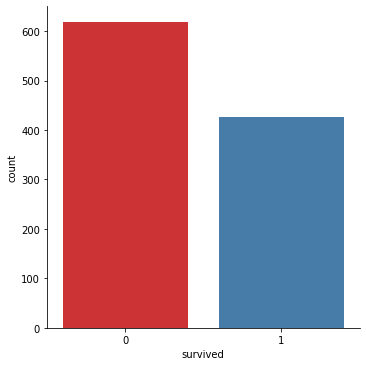

In [7]:
sns.set_palette("Set1")
sns.catplot(data=df,
           x='survived',
           kind='count')
plt.show()

### Czy klasa którą podróżowały osoby, miała wpływ na przeżycie?<br>

1 – to klasa najwyższa (premium). Być może, osoby podróżujące tą klasą, miały priorytet przy ewakuacji, analogicznie do osób wsiadających do samolotu na lotnisku, a być może ich kajuty, były zlokalizowane w specyficznej części statku. Ułatwiającej lub utrudniającej ewakuację.

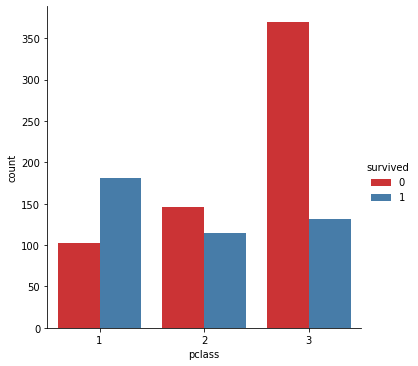

In [8]:
sns.catplot(data=df,
           x='pclass',
           kind = 'count',
           hue= 'survived')
plt.show()

### Czy wiek osoby, miał wpływ na przeżycie? <br>
Widzimy, że większość dzieci przeżyła. Nie ma widocznej różnicy, dla osób po 20 roku życia.<br>
Zapewne dzieci były traktowane priorytetowo.

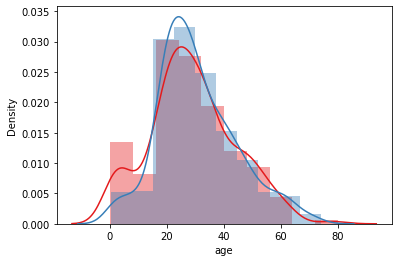

In [9]:
sns.distplot(df[df['age'].notnull() & (df['survived']==1)]['age'], 
             kde_kws={"label": "Survived"}, 
             bins=10)
sns.distplot(df[df['age'].notnull() & (df['survived']==0)]['age'], 
             kde_kws={"label": "Not Survived"}, 
             bins=10)
plt.show()

### Czy płeć osoby, miała wpływ na przeżycie?<br>
Kobiety miały większe szanse na przeżycie. Prawdopodobnie miały pierwszeństwo

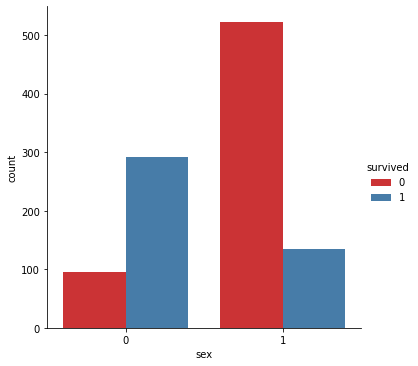

In [10]:
sns.catplot(data=df,
           x = 'sex',
           hue = 'survived',
           kind='count')
plt.show()

# Klasteryzacja

## Zbiór danych użyty do klasteryzacji: <font color="green">_multishapes.csv_</font>
https://www.rdocumentation.org/packages/factoextra/versions/1.0.7/topics/multishapes  (1100 obserwacji i 3 zmienne) <br><br>

__Krótki opis zbioru:__<br>
Dane zawierające klastry dowolnych kształtów.<br><br>

__Opis zmiennych:__<br>
__<font color="green">x</font>__ - wektor numeryczny zawierający współrzędne obserwacji x,<br>
__<font color="green">y</font>__ - wektor numeryczny zawierający współrzędne obserwacji y,<br>
__<font color="green">shapes</font>__ - wektor numeryczny odpowiadający numerowi klastra każdej obserwacji. <br><br>

Algorytmy klasteryzacji wybrane przeze mnie. ___KMeans___ i ___DBScan___<br><br>

Jeśli chodzi o obróbke danych to trzeba było je przeskalować, aby poszczególne pomiary nie dominowały w późniejszych obliczeniach.

In [11]:
multishapes = pd.read_csv("multishapes.csv")
ms_df = multishapes[['x','y']]
ms_df.describe()

scaled_df = pd.DataFrame(preprocessing.scale(ms_df), index=multishapes['shape'], columns = ms_df.columns)
scaled_df.describe()

scaled_df


,x,y
shape,,
1,-1.120749,-0.193616
1,1.448907,0.844692
1,1.564203,0.298161
1,-1.041463,0.096855
1,1.222429,1.221561
...,...,...
6,1.609007,-1.572253
6,1.569755,-1.480985
6,1.660958,-1.573442


### Przedstawienie zbioru w formie graficznej

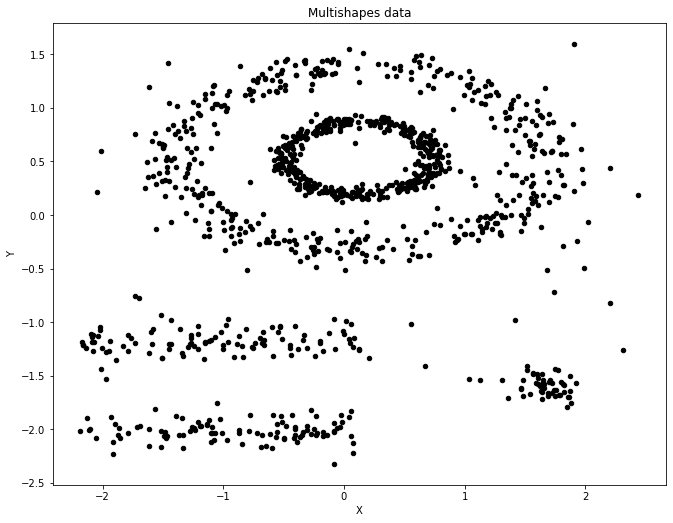

In [12]:
msplot = scaled_df.plot.scatter(x='x',y='y',c='Black',title="Multishapes data",figsize=(11,8.5))
msplot.set_xlabel("X")
msplot.set_ylabel("Y")
plt.show()

# <font color="green">KMeans</font>

Do znalezienia 'optymalnej' liczby klastrów - ręcznie zapętliłem algorytm _KMeans_ , aby później przedstawić jego wyniki na wykresie i wybrać najlepsze _n_.

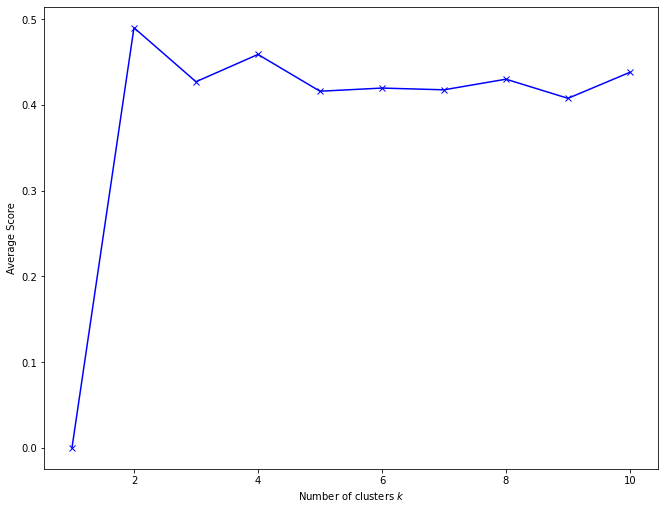

In [13]:
from sklearn.metrics import silhouette_score

scores = [0]
for i in range(2,11):
    fitx = KMeans(n_clusters=i, init='random', n_init=5, random_state=109).fit(scaled_df)
    score = silhouette_score(scaled_df, fitx.labels_)
    scores.append(score)
    
plt.figure(figsize=(11,8.5))
plt.plot(range(1,11), np.array(scores), 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Average Score')
plt.show()

Wykres sugeruje za _n_ przyjąć 2.

### n_clusters = 2

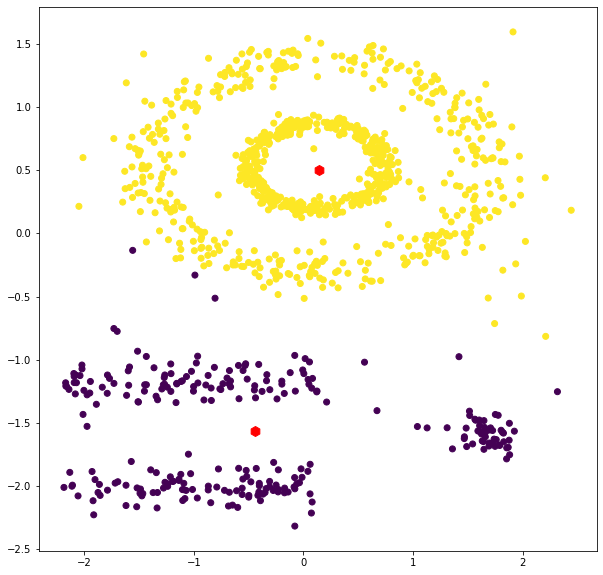

In [14]:
ms_kmeans = KMeans(n_clusters=2, init='random', n_init=2, random_state=109).fit(scaled_df)

plt.figure(figsize=(10,10))
plt.scatter(scaled_df['x'],scaled_df['y'], c=ms_kmeans.labels_);
plt.scatter(ms_kmeans.cluster_centers_[:,0],ms_kmeans.cluster_centers_[:,1], c='r', marker='h', s=100);


### n_clusters = 3

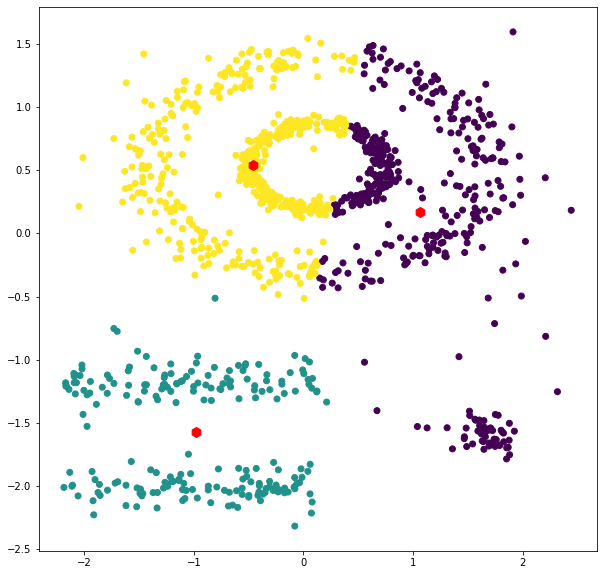

In [15]:
ms_kmeans = KMeans(n_clusters=3, init='random', n_init=3, random_state=109).fit(scaled_df)

plt.figure(figsize=(10,10))
plt.scatter(scaled_df['x'],scaled_df['y'], c=ms_kmeans.labels_);
plt.scatter(ms_kmeans.cluster_centers_[:,0],ms_kmeans.cluster_centers_[:,1], c='r', marker='h', s=100);


### n_clusters = 5

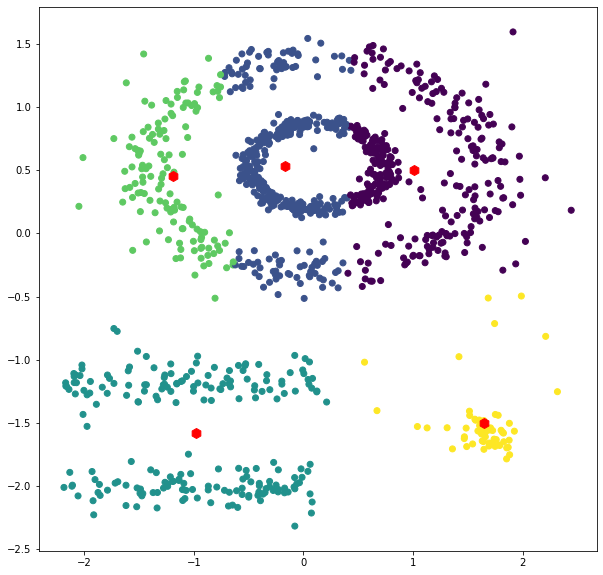

In [16]:
ms_kmeans = KMeans(n_clusters=5, init='random', n_init=5, random_state=109).fit(scaled_df)

plt.figure(figsize=(10,10))
plt.scatter(scaled_df['x'],scaled_df['y'], c=ms_kmeans.labels_);
plt.scatter(ms_kmeans.cluster_centers_[:,0],ms_kmeans.cluster_centers_[:,1], c='r', marker='h', s=100);


<font color="red">Jak widać na wykresach wybór odpowiedniej liczby klastrów jest bardzo ważny do prawidłowej klasteryzacji.</font>

# vs<br><font color="green">DBScan</font>

Zamiast obserwować jak wartość _epsilon_ wpływa na klastrowanie _DBScan_'em w pętli (co byłoby czasochłonne i dla dużych, wysokowymiarowych danych złożone obliczeniowo), możemy sprawdzić, jak daleko każdy punkt ma do N-tego najbliższego sąsiada:

In [17]:
from sklearn.neighbors import NearestNeighbors

def plot_epsilon(df, min_samples):
    fitted_neigbors = NearestNeighbors(n_neighbors=min_samples).fit(df)
    distances, indices = fitted_neigbors.kneighbors(df)
    dist_to_nth_nearest_neighbor = distances[:,-1]
    plt.plot(np.sort(dist_to_nth_nearest_neighbor))
    plt.xlabel("Index\n(sorted by increasing distances)")
    plt.ylabel("Epsilon")
    plt.tick_params(right=True, labelright=True)

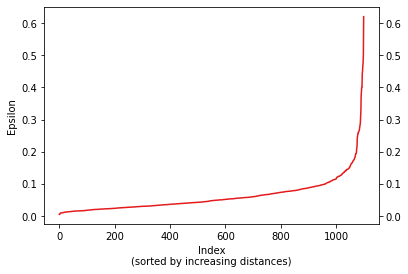

In [18]:
plot_epsilon(scaled_df, 3)

Na podstawie wykresu _eps = 0.2_ będzie najefektywniejszy.

### eps = 0.1

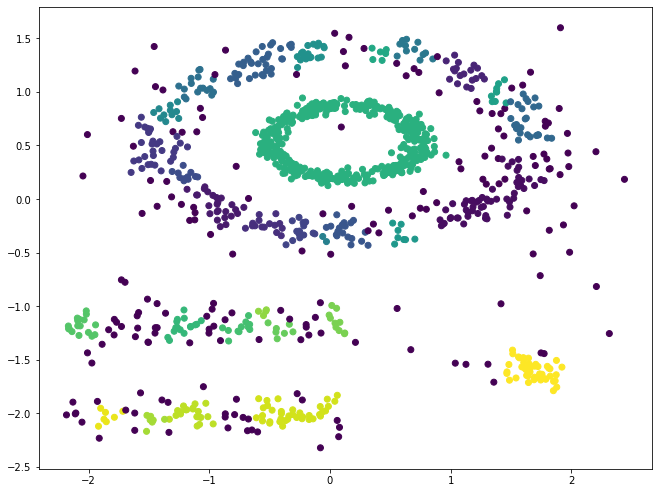

In [19]:
plt.figure(figsize=(11,8.5))
fitted_dbscan = DBSCAN(eps=0.1).fit(scaled_df)
plt.scatter(scaled_df['x'],scaled_df['y'], c=fitted_dbscan.labels_);

### eps = 0.2

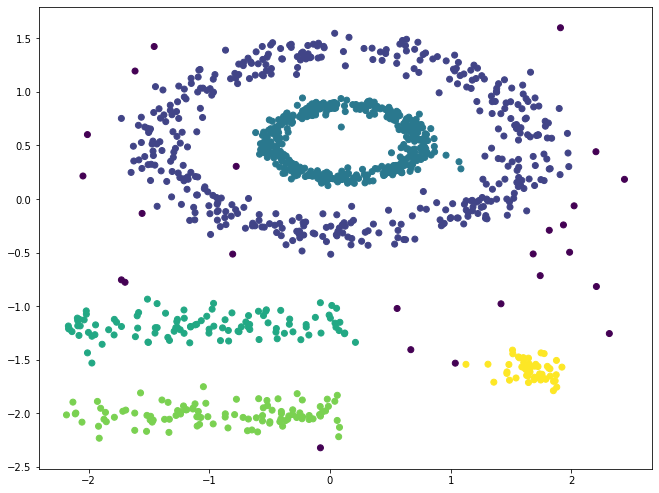

In [20]:
plt.figure(figsize=(11,8.5))
fitted_dbscan = DBSCAN(eps=0.2).fit(scaled_df)
plt.scatter(scaled_df['x'],scaled_df['y'], c=fitted_dbscan.labels_);

### eps = 0.6

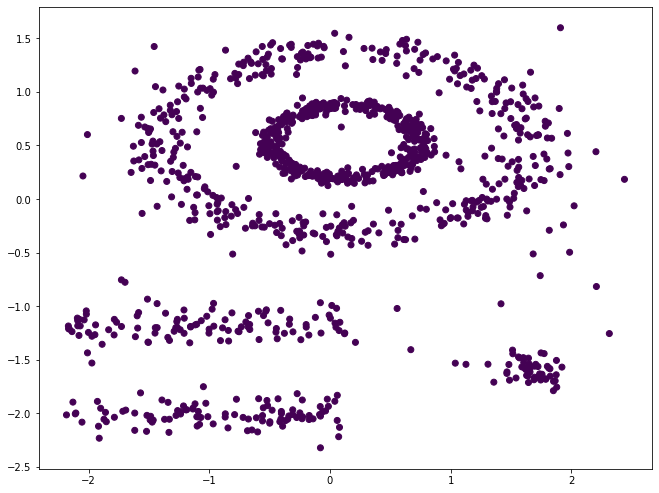

In [21]:
plt.figure(figsize=(11,8.5))
fitted_dbscan = DBSCAN(eps=0.6).fit(scaled_df)
plt.scatter(scaled_df['x'],scaled_df['y'], c=fitted_dbscan.labels_);

<font color="red">Tak samo tutaj słabo dobrany epsilon będzie dawał słabe wyniki, tak więc warto znać funkcje, dzięki którym z łatwością określimy najlepsze parametry.</font>